In [126]:
import numpy as np
import pandas as pd
import sympy as sp
import cvxpy as cp
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from scipy.constants import convert_temperature as conv_temp

# from Classes import LEDparams

# Simple PID library https://github.com/m-lundberg/simple-pid/tree/master (Documentation: https://pypi.org/project/simple-pid/)
from simple_pid import PID

from scipy.linalg import solve_discrete_are

In [ ]:
class LEDparams:
    def __init__(self) -> None:
        self.I_LED = 0.017 # A
        
        # Identified at 0.017 A at 25°C
        radiant_power_dict = {
            'IR':       5.94,
            'Red':      1.70,
            'Orange':   1.18,
            'Green':    4.60,
            'Blue':     6.56,
            'Purple':   8.21,
            'UV':       3.92
        } # mW/cm^2

        # Convert to numpy array
        specific_radiant_power = np.array([radiant_power_dict[color] for color in radiant_power_dict.keys()]) # mW/cm^2

        # Single hole
        diameter = 6.7 # mm
        cross_section = np.pi * (diameter/10/2)**2 # cm^2
        self.radiant_power = cross_section * specific_radiant_power / 1000 # W

        # Dimensions for checking
        num_colors = len(specific_radiant_power)
        plate_row = 8
        plate_col = 12
        self.dimensions = (num_colors, plate_row, plate_col)

    def program_reader(self) -> np.ndarray:
        """ Returns the total duty cycle, single LED constant current and total radiant power"""
        x_matrix = np.random.randint(0, 2**16-1, self.dimensions) # TODO implement program reader
        x_matrix = x_matrix / 5 # TODO dcrease losses

        x_matrix_scaled = x_matrix / (2**16-1) # duty cycle

        self.P_r = np.sum(x_matrix_scaled * self.radiant_power[:, np.newaxis, np.newaxis]) # W

        self.x_LED_tot = np.sum(x_matrix_scaled) # total duty cycle assuming equal current for all LEDs

        return self.x_LED_tot, self.I_LED, self.P_r

class Model:
    def __init__(self, LEDparams:LEDparams, x0:np.ndarray, T_amb0:float=conv_temp(25.0, 'C', 'K')) -> None:
        """
        x0 : Initial state

        u1: current through the peltier module
        u2: PWM fan

        x1: SoC
        x2: T_HP_c
        x3: T_HP_h
        """
        # State input initialization
        self.x = x0
        self.u = np.array([0.0, 0.0])

        # Parameters initialization
        self._init_params(LEDparams, T_amb0)

        # Dictionary to connect symbolic variables with values
        self.params_values = {
            'n_BT':         self.n_BT, # Battery
            'Q_max':        self.Q_BT_max,
            'R_in':         self.R_BT_int,
            'P_rest':       self.P_el_rest,
            'a3':           self.BT_coefs["a3"].iloc[0],
            'a2':           self.BT_coefs["a2"].iloc[0],
            'a1':           self.BT_coefs["a1"].iloc[0],
            'a0':           self.BT_coefs["a0"].iloc[0],
            'U_FAN':        self.U_FAN, # Fan
            'I_FAN':        self.I_FAN,
            'y_FAN':        self.FAN_coefs["y_min"].iloc[0],
            'a_FAN':        self.FAN_coefs["a"].iloc[0],
            'b_FAN':        self.FAN_coefs["b"].iloc[0],
            'k_FAN':        self.FAN_coefs["k"].iloc[0],
            'I_LED':        self.I_LED, # LED
            'x_LED':        self.x_LED,
            'P_r':          self.P_LED_r,
            'S_M':          self.S_M, # HP
            'R_M':          self.R_M,
            'K_M':          self.K_M,
            'cp_Al':        self.cp_Al, # Thermal
            'cp_w':         self.cp_H2O,
            'T_amb':        self.T_amb,
            'm_c':          self.m_2 + self.m_4,
            'm_h':          self.m_1,
            'R_floor':      self.R_floor_lambda,
            'R4_lambda':    self.R_4_lambda,
            'R5':           self.R_5,
        }

        # Operational point initialization
        self._init_operational_point()

        # Symbolic initialization
        self._init_sym_model()

    def _init_params(self, LEDparams:LEDparams, T_amb0:float) -> None:
        self.P_el_rest = 1.0 # W TODO get better value
        self.n_BT = 2
        self.Q_BT_max = 3.0 * 3600 # As (Ah = 3600 As)
        self.R_BT_int = 0.1 # Ohm
        self.BT_coefs = pd.read_csv(
            'C:\\Users\\giaco\\Git_Repositories\\Semester_Thesis_1\\Data\\Battery\\battery_fitted_coefficients_3rd.csv'
            )

        # Fan parameters
        self.I_FAN = 0.13 # A
        self.U_FAN = 12.0 # V
        self.FAN_coefs = pd.read_csv(
            'C:\\Users\\giaco\\Git_Repositories\\Semester_Thesis_1\\Data\\Fan\\fan_coefficients.csv'
            )

        # LED parameters
        self.I_LED = LEDparams.I_LED # A
        self.x_LED = LEDparams.x_LED_tot # duty cycle
        self.P_LED_r = LEDparams.P_r # W

        # Thermal parameters
        self.T_amb = T_amb0 # K
        self.cp_Al = 897.0 # J/kgK https://en.wikipedia.org/wiki/6061_aluminium_alloy
        self.cp_H2O = 4180.0 # J/kgK https://www.engineeringtoolbox.com/specific-heat-capacity-water-d_660.html
        # self.cp_air = 1006.0 # J/kgK https://www.engineeringtoolbox.com/air-specific-heat-capacity-d_705.html?vA=37&degree=C&pressure=1bar#

        # Top thermal parameters - Diffuser
        # TODO estimation of parameters
        self.R_4_lambda = 0.5 # K/W
        self.R_5 = 25.0 # K/W

        # Top Al thermal parameters
        self.m_2 = 0.0638 # kg
        self.m_4 = 0.0642 # kg

        # Bottom Al thermal parameters - Heat sink
        self.m_1 = 0.0876 # kg
        self.R_floor_lambda = 2.6 # K/W # TODO estimated real time

        # Heat pump - peltier module
        HP_params = pd.read_csv(
            'C:\\Users\\giaco\\Git_Repositories\\Semester_Thesis_1\\Data\\Heat Pump\\HP_fitted_coefficients.csv'
            )
        self.R_M = HP_params["R_M"].iloc[0] # Ohm
        self.S_M = HP_params["S_M"].iloc[0] # V/K
        self.K_M = HP_params["K_M"].iloc[0] # W/K

        I_HP_max_datasheet = HP_params["I_max"].iloc[0] # A
        I_HP_max_electronics = 3.0 # A when attached to the battery
        self.I_HP_max = min(I_HP_max_datasheet, I_HP_max_electronics) # A

    def _init_operational_point(self) -> None:
        x_SoC = 0.85
        T_c   = conv_temp(self.T_amb, 'C', 'K') # K
        T_h   = conv_temp(self.T_amb + 30.0, 'C', 'K') # K
        I_HP  = 1.2 # A
        x_FAN = 1.0 # duty cycle

        self.x_op = np.array([x_SoC, T_c, T_h])
        self.u_op = np.array([I_HP, x_FAN])

    def _init_sym_model(self) -> None:
        # State variables
        x_SoC, T_c, T_h = sp.symbols('x_SoC, T_c, T_h')
        self.sym_x      = sp.Matrix([x_SoC, T_c, T_h])

        # Input variables
        I_HP, x_FAN = sp.symbols('I_HP, x_FAN')
        self.sym_u  = sp.Matrix([I_HP, x_FAN])

        # Battery parameters
        n, Q_max, R_in, P_rest = sp.symbols('n_BT, Q_max, R_in, P_rest')
        a3, a2, a1, a0 = sp.symbols('a3, a2, a1, a0')
        U_oc = a3 * x_SoC**3 + a2 * x_SoC**2 + a1 * x_SoC + a0 # V
        # display(Markdown(r"$U_{oc}(x_{SoC}):$"), U_oc.subs(self.params_values))

        # Fan parameters
        U_FAN, I_FAN = sp.symbols('U_FAN, I_FAN')
        y_min, a, b, k = sp.symbols('y_FAN, a_FAN, b_FAN, k_FAN')
        R_air_alpha = y_min + (1 / (x_FAN + a) + b - y_min) / (1 + sp.exp(-k * x_FAN)) # K/W
        # display(Markdown(r"$R_{air}^\alpha(x_{FAN}):$"), R_air_alpha)
        # display(Markdown(r"$R_{air}^\alpha(x_{FAN}=1):$"), R_air_alpha.subs(self.params_values).subs({x_FAN: 1.0}))
        # display(Markdown(r"$R_{air}^\alpha(x_{FAN}=0):$"), R_air_alpha.subs(self.params_values).subs({x_FAN: 0.0}))

        # LED parameters
        I_LED, x_LED, P_r = sp.symbols('I_LED, x_LED, P_r')

        # HP parameters - Peltier module
        S_M, R_M, K_M = sp.symbols('S_M, R_M, K_M')
        U_HP = S_M * (T_h - T_c) + R_M * I_HP # V
        Q_c = S_M * I_HP * T_c - 0.5 * R_M * I_HP**2 - K_M * (T_h - T_c) # W

        # Thermal parameters
        cp_Al, T_amb = sp.symbols('cp_Al, T_amb')

        # Top thermal parameters - Diffuser
        R4_lambda, R5 = sp.symbols('R4_lambda, R5')
        Q_LEDcell = (T_c - T_amb) / (R5 + R4_lambda) # W

        # Top Al thermal parameters - Diffuser
        m_c = sp.symbols('m_c')

        # Bottom Al thermal parameters - Heat sink
        m_h, R_floor_lambda = sp.symbols('m_h, R_floor')
        R_eq = (R_floor_lambda * R_air_alpha) / (R_floor_lambda + R_air_alpha) # K/W
        # display(Markdown(r"$R_{eq}(x_{FAN}=1):$"), R_eq.subs(self.params_values).subs({x_FAN: 1.0}))
        # display(Markdown(r"$R_{eq}(x_{FAN}=0):$"), R_eq.subs(self.params_values).subs({x_FAN: 0.0}))

        ### Calculations
        # Output: T_cell
        T_cell = R5 * Q_LEDcell + T_amb # K
        # display(Markdown(r"$T_{cell}:$"), T_cell.subs(self.params_values))

        # Output: I_BT
        # I_BT = U_oc + R_in * I_HP + R_in * I_LED * x_LED - sp.sqrt(U_oc**2 - 2 * R_in * I_LED * x_LED * U_oc - 2 * R_in * U_oc * I_HP + R_in**2 * I_HP**2 + 2 * R_in * I_LED * x_LED * R_in * I_HP - 4 * R_in * I_FAN * U_FAN * x_FAN - 4 * R_in * P_rest + (R_in * I_LED * x_LED)**2) # A
        I_BT = U_oc + R_in * sp.sqrt(I_HP**2) + R_in * I_LED * x_LED - sp.sqrt(U_oc**2 - 2 * R_in * I_LED * x_LED * U_oc - 2 * R_in * U_oc * sp.sqrt(I_HP**2) + R_in**2 * I_HP**2 + 2 * R_in * I_LED * x_LED * R_in * sp.sqrt(I_HP**2) - 4 * R_in * I_FAN * U_FAN * x_FAN - 4 * R_in * P_rest + (R_in * I_LED * x_LED)**2) # A
        U_BT = U_oc - R_in * I_BT # V
        # display(Markdown(r"$U_{BT}:$"), U_BT.subs(self.params_values))

        # HP calculation
        P_HP = U_HP * I_HP # W
        COP = 1 + Q_c / P_HP

        # LED calculation
        P_LED = I_LED * U_BT * x_LED # W
        Q_LED = P_LED - P_r # W

        # Nonlinear ODEs
        dTh_dt = (1 / (m_h * cp_Al)) * (Q_c + P_HP - (T_h - T_amb) / R_eq)
        dTc_dt = (1 / (m_c * cp_Al)) * (Q_LED - Q_LEDcell - Q_c)
        dxSoC_dt = - I_BT / (n * Q_max)

        # Symbolic dynamics, output and linearization
        self.f_symb = sp.Matrix([dxSoC_dt, dTc_dt, dTh_dt])
        self.g_symb = sp.Matrix([T_cell, I_BT])
        # display(Markdown(r"$\dot{x} = f(x, u):$"), self.f_symb)
        # display(Markdown(r"$y = g(x, u):$"), self.g_symb)

        self.A_symb = self.f_symb.jacobian(self.sym_x)
        self.B_symb = self.f_symb.jacobian(self.sym_u)
        self.C_symb = self.g_symb.jacobian(self.sym_x)
        self.D_symb = self.g_symb.jacobian(self.sym_u)
        # display(Markdown(r"$A = \nabla_x f:$"), self.A_symb.subs(self.params_values).subs({x_SoC: 0.85, T_c: 25.0, T_h: 55.0, x_FAN: 1.0}))
        # display(Markdown(r"$B = \nabla_u f:$"), self.B_symb.subs(self.params_values).subs({x_SoC: 0.85, T_c: 25.0, T_h: 55.0, x_FAN: 1.0}))

        # Create numerical functions with parameters already inserted
        self.f_num = sp.lambdify((self.sym_x, self.sym_u), self.f_symb.subs(self.params_values), modules="numpy")
        self.g_num = sp.lambdify((self.sym_x, self.sym_u), self.g_symb.subs(self.params_values), modules="numpy")

        self.A_num = sp.lambdify((self.sym_x, self.sym_u), self.A_symb.subs(self.params_values), modules="numpy")
        self.B_num = sp.lambdify((self.sym_x, self.sym_u), self.B_symb.subs(self.params_values), modules="numpy")
        self.C_num = sp.lambdify((self.sym_x, self.sym_u), self.C_symb.subs(self.params_values), modules="numpy")
        self.D_num = sp.lambdify((self.sym_x, self.sym_u), self.D_symb.subs(self.params_values), modules="numpy")

        ## Values
        # Voltages
        self.U_BT_num = sp.lambdify((self.sym_x, self.sym_u), U_BT.subs(self.params_values), modules="numpy")
        self.U_oc_num = sp.lambdify((self.sym_x, self.sym_u), U_oc.subs(self.params_values), modules="numpy")
        self.U_HP_num = sp.lambdify((self.sym_x, self.sym_u), U_HP.subs(self.params_values), modules="numpy")
        self.COP_num  = sp.lambdify((self.sym_x, self.sym_u), COP.subs(self.params_values), modules="numpy")

    def get_linearization(self, xss:np.ndarray=None, uss:np.ndarray=None) -> np.ndarray:
        if xss is None:
            xss = self.x_op
        if uss is None:
            uss = self.u_op

        A = self.A_num(xss, uss)
        B = self.B_num(xss, uss)
        h = self.f_num(xss, uss)
        C = self.C_num(xss, uss)
        D = self.D_num(xss, uss)
        l = self.g_num(xss, uss)

        return np.array(A).astype(np.float32), np.array(B).astype(np.float32), np.array(h).astype(np.float32), np.array(C).astype(np.float32), np.array(D).astype(np.float32), np.array(l).astype(np.float32)
    
    def dynamics_f(self, x:np.ndarray, u:np.ndarray) -> np.ndarray:
        return np.array(self.f_num(x, u)).flatten()

    def observer_g(self, x:np.ndarray, u:np.ndarray) -> np.ndarray:
        return np.array(self.g_num(x, u)).flatten()

    def discretized_update(self, u:np.ndarray, dt:float) -> np.ndarray:
        """
        Update the states using Runge-Kutta of 4th order integration.
        """
        x = self.x

        # Bound input
        u = self._input_bounds(x, u)

        # Runge-Kutta 4th order
        k = np.zeros((4, len(x)))
        k[0] = self.dynamics_f(x, u)
        k[1] = self.dynamics_f(x + 0.5 * dt * k[0], u)
        k[2] = self.dynamics_f(x + 0.5 * dt * k[1], u)
        k[3] = self.dynamics_f(x + dt * k[2], u)

        self.x = x + (dt / 6.0) * (k[0] + 2 * k[1] + 2 * k[2] + k[3])
        self.u = u

        # Bound states
        self.x = self._states_bounds(self.x)
        
        return self.x
    
    def get_output(self) -> np.ndarray:
        return self.observer_g(self.x, self.u)
    
    def get_values(self, x:np.ndarray, u:np.ndarray) -> np.ndarray:
        U_BT = np.array(self.U_BT_num(x, u)).flatten()
        U_oc = np.array(self.U_oc_num(x, u)).flatten()
        U_HP = np.array(self.U_HP_num(x, u)).flatten()
        COP  = np.array(self.COP_num(x, u)).flatten()
        return np.array([U_BT, U_oc, U_HP, COP]).flatten()

    def _input_bounds(self, x:np.ndarray, u:np.ndarray) -> np.ndarray:
        u[0] = np.clip(u[0], -self.I_HP_max, self.I_HP_max)

        I_HP_max_I_source = (self.U_BT_num(x, u) - self.S_M * (x[2] - x[1])) / self.R_M
        I_HP_min_I_source = (-self.U_BT_num(x, u) - self.S_M * (x[2] - x[1])) / self.R_M
        u[0] = np.clip(u[0], I_HP_min_I_source, I_HP_max_I_source)

        u[1] = np.clip(u[1], 0.0, 1.0)
        return u
    
    def _states_bounds(self, x:np.ndarray) -> np.ndarray:
        x[0] = np.clip(x[0], 0.0, 1.0)
        x[1] = np.clip(x[1], 0.0, conv_temp(100.0, 'C', 'K'))
        x[2] = np.clip(x[2], 0.0, conv_temp(100.0, 'C', 'K'))
        return x

class BasicController:
    def __init__(self) -> None:
        pass

    def get_control_input(self, current_output) -> np.ndarray:
        u_HP = 0.0
        u_FAN = 0.0
        return np.array([u_HP, u_FAN])

class PIDController:
    def __init__(self, kp:float, ki:float, kd:float, setpoint:float, dt:float, output_limits:tuple) -> None:
        # to work, the sample time has to be zero
        self.pid = PID(Kp=kp, Ki=ki, Kd=kd, setpoint=setpoint, sample_time=dt, output_limits=output_limits)

    def get_control_input(self, current_output:float) -> np.ndarray:
        u_HP = self.pid(current_output)
        u_FAN = 1.0
        return np.array([u_HP, u_FAN])

class LQRController:
    """ Infinite horizon LQR controller """
    def __init__(self, A:np.ndarray, B:np.ndarray, Q:np.ndarray, R:np.ndarray) -> None:
        # Check dimensions of A, B, Q, R
        if A.shape[0] != A.shape[1]:
            raise ValueError("Matrix A must be square.")
        if B.shape[0] != A.shape[0]:
            raise ValueError("Matrix B must have the same number of rows as A.")
        if Q.shape != A.shape:
            raise ValueError("Matrix Q must have the same dimensions as A.")
        if R.shape[0] != R.shape[1] or R.shape[0] != B.shape[1]:
            raise ValueError("Matrix R must be square and match the number of columns of B.")

        # Check if Q and R are (semi)positive definite
        if not self.is_positive_definite(Q):
            raise ValueError("Matrix Q must be positive semi-definite.")
        if not self.is_positive_definite(R):
            raise ValueError("Matrix R must be positive definite.")
        
        # Check controllability and observability
        if not self.is_controllable(A, B):
            raise ValueError("The system is not controllable with the given A and B matrices.")
        
        if not self.is_observable(A, C):
            raise ValueError("The system is not observable with the given A and C matrices.")


        # Solve Riccati equation
        self.P = solve_discrete_are(A, B, Q, R)
        self.K = -np.linalg.inv(R + B.T @ self.P @ B) @ B.T @ self.P @ A

    def get_control_input(self, current_state) -> np.ndarray:
        return self.K @ current_state

    @staticmethod
    def is_positive_definite(X:np.ndarray) -> bool:
        try:
            # Attempt Cholesky decomposition to check positive definiteness
            np.linalg.cholesky(X)
            return True
        except np.linalg.LinAlgError:
            return False
        
    @staticmethod
    def is_controllable(A, B):
        n = A.shape[0]
        controllability_matrix = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n)])
        return np.linalg.matrix_rank(controllability_matrix) == n
    
    @staticmethod
    def is_observable(A, C):
        n = A.shape[0]
        observability_matrix = np.vstack([C @ np.linalg.matrix_power(A, i) for i in range(n)])
        return np.linalg.matrix_rank(observability_matrix) == n

class TrackingMPController_discrete:
    def __init__(self, model:Model, Q:np.ndarray, S:np.ndarray, R:np.ndarray, pred_time:int, sampling_time:int, discret_time:int, print_output:bool=False, verbose:bool=False) -> None:
        self.Q = Q
        self.S = S
        self.R = R
        self.pred_time = pred_time
        self.sampling_time = sampling_time
        self.discret_time = discret_time

        self.K = int(pred_time / discret_time)

        self.n = 3 # number of states
        self.m = 2 # number of inputs

        self.A, self.B, self.h, _, _, _ = model.get_linearization()

        self.print_output = print_output
        self.verbose = verbose
        self.num_infeas = 0
        self.num_None_output = 0

        self._init_optimization_problem()

    def _init_optimization_problem(self) -> None:
        # Define variables and dynamic parameters for the optimization problem
        self.x_var          = cp.Variable((self.n, self.K+1))
        self.i_var          = cp.Variable((self.m, self.K))
        self.x0_param       = cp.Parameter(self.n)

        # Placeholders for parametrization
        self.A_d = cp.Parameter((self.n, self.n))
        self.B_d = cp.Parameter((self.n, self.m))
        self.h_d = cp.Parameter(self.n)
        self.xss = cp.Parameter(self.n)

        # Initialize cost and constraints (parametrized)
        self.cost = 0
        self.constraints = [self.x_var[:, 0] == self.x0_param]
        
        # Iterate over the horizon K - 1 for cost and constraints
        for k in range(self.K):
            self.cost += (
                cp.quad_form(self.x_var[:, k] - self.xss, self.Q) + 
                cp.quad_form(self.i_var[k], self.R)
                )
            self.constraints += [
                self.x_var[:, k+1] == self.A_d @ self.x_var[:, k] + self.B_d * self.i_var[k] + self.h_d,
                self.i_var[0, k]   >= - self.model.I_HP_max,
                self.i_var[0, k]   <= self.model.I_HP_max,
                self.i_var[1, k]   >= 0,
                self.i_var[1, k]   <= 1,
                self.x_var[0, k]   >= 0,
                self.x_var[0, k]   <= 1,
                ]
        
        # Terminal cost or constraint for stability
        self.cost += cp.quad_form(self.x_var[:, self.K] - self.xss, self.S)
        # self.constraints += [self.x_var[:, self.K_d] == self.xss]

        self.problem = cp.Problem(cp.Minimize(self.cost), self.constraints)

        if self.print_output:
            print("Is the problem DPP compliant?", self.problem.is_dpp())
            print("Is the problem DCP compliant?", self.problem.is_dcp())

    def _update_linearized_matrices(self, A:np.ndarray, B:np.ndarray, h:np.ndarray) -> None:
        self.A_d.value = A
        self.B_d.value = B
        self.h_d.value = h

    def get_control_input(self, x0, time_index, xss, dss) -> tuple:
        if self.print_output:
            print(f"--  Simulation time: {time_index} min  -  Infeasible solutions: {self.num_infeas} of which None output: {self.num_None_output}  --")
        
        # Save uss and xss at the beginning of the simulation
        if time_index == 0:
            self.xss.value = xss

            # Initialize the open-loop input
            dss.basal_handler_params['open-loop input'] = np.ones(self.K)
        
        # Optimization at every sampling time
        if (time_index % self.sampling_time) == 0:

            self.x0_param.value = x0
        
            # Solve the optimization problem
            try:
                self.problem.solve(solver=cp.MOSEK, verbose=self.verbose)

                # Check if the solution is available
                if self.i_var.value is None:
                    raise Exception("Solver did not find a feasible solution.")
            
            # Fallback solver
            except:
                try:
                    self.problem.solve(solver=cp.CLARABEL, verbose=self.verbose)

                    # Check if the solution is available
                    if self.i_var.value is None:
                        self.num_None_output += 1
                        raise Exception("Fallback solver did not find a feasible solution.")

                except:
                    self.num_infeas += 1
                    
                    control_output = dss.basal_handler_params['open-loop input'][time_index % self.sampling_time]

                    if self.print_output:
                        print(f"Forced control output: {control_output}")
                    return control_output, dss
            
            # Problem solved
            control_output = self.i_var.value

            # Save open-loop input
            dss.basal_handler_params['open-loop input'] = np.repeat(self.i_var[:].value, self.discret_time)

            if self.print_output:
                print(f"Optimized control output: {control_output}")
            return control_output, dss
        
        # Open-loop control
        else:
            control_output = dss.basal_handler_params['open-loop input'][time_index % self.sampling_time]
            
            if self.print_output:
                print(f"Open-loop control output: {control_output}")
            return control_output, dss

class Simulation:
    def __init__(self, model, controller, dt, time_span) -> None:
        self.model = model
        self.controller = controller
        self.dt = dt
        self.time_span = time_span

    def run(self) -> pd.DataFrame:
        time_steps = int(self.time_span / self.dt)
        
        data = {
            "time":     [],
            "SoC":      [],
            "T_HP_c":   [],
            "T_HP_h":   [],
            "I_HP":     [],
            "x_FAN":    [],
            "T_cell":   [],
            "I_BT":     [],
            "U_BT":     [],
            "U_oc":     [],
            "U_HP":     [],
            "COP":      [],
        }

        for t in range(time_steps):
            current_time = t * self.dt

            # print(f"------------- {current_time} -------------")

            y = self.model.get_output()

            u = self.controller.get_control_input(y[0])

            # Advance system states
            x = self.model.discretized_update(u, self.dt)

            # Get internal values
            values = self.model.get_values(x, u)

            data["time"].append(current_time)
            data["SoC"].append(x[0])
            data["T_HP_c"].append(x[1])
            data["T_HP_h"].append(x[2])
            data["I_HP"].append(u[0])
            data["x_FAN"].append(u[1])
            data["T_cell"].append(y[0])
            data["I_BT"].append(y[1])
            data["U_BT"].append(values[0])
            data["U_oc"].append(values[1])
            data["U_HP"].append(values[2])
            data["COP"].append(values[3])

        return pd.DataFrame(data)

In [128]:
LEDpar = LEDparams()
LEDpar.program_reader()

# Initial conditions
T_amb0 = conv_temp(25.0, 'C', 'K') # K
x0 = np.array([0.9, T_amb0, T_amb0])

model = Model(LEDpar, x0, T_amb0=T_amb0)

dt_sim = 1 # s
time_span = 60 * 10 # s

assert time_span > 0, "Time span must be positive."
assert time_span >= dt_sim, "Time span must be greater than or equal to the time step."

dt_disc = 0.0

kp, ki, kd = -2.5, -4.0, 0.0
setpoint = conv_temp(37.0, 'C', 'K') # K
output_limits = (-model.I_HP_max, model.I_HP_max) # A
controller = PIDController(kp, ki, kd, setpoint, dt_disc, output_limits)

A, B, h, C, D, l = model.get_linearization()
Q = np.eye(A.shape[0])
R = np.eye(B.shape[1])

sim = Simulation(model, controller, dt_sim, time_span)

# Run the simulation
results = sim.run()

# Conversion
results[["T_cell", "T_HP_c", "T_HP_h"]] = conv_temp(results[["T_cell", "T_HP_c", "T_HP_h"]].to_numpy(), 'K', 'C')

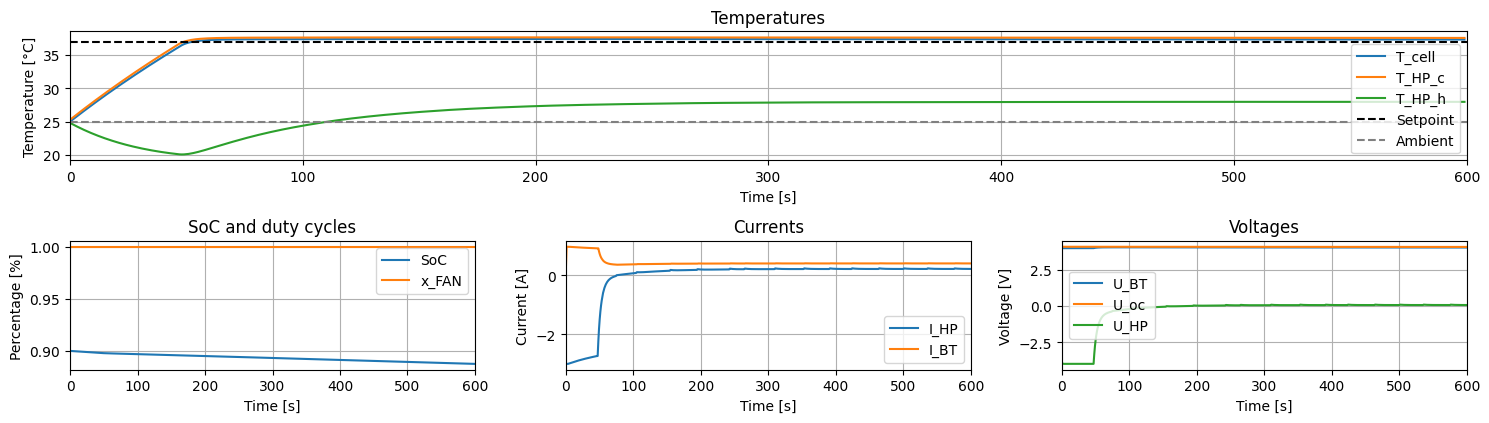

In [129]:
xlimits = (0, time_span)

fig = plt.figure(figsize=(15, 6))

gs = fig.add_gridspec(3, 3)

# Temperatures
ax0 = fig.add_subplot(gs[0, :])  # Span the first row across both columns
ax = results.plot(
    x="time", 
    y=["T_cell", "T_HP_c", "T_HP_h"], 
    xlabel="Time [s]", 
    ylabel="Temperature [°C]", 
    title="Temperatures",
    ax=ax0
)
ax.axhline(
    y=conv_temp(setpoint, 'K', 'C'), 
    color='black', 
    linestyle='--', 
    label='Setpoint'
)
ax.axhline(
    y=conv_temp(T_amb0, 'K', 'C'), 
    color='gray', 
    linestyle='--', 
    label='Ambient'
)
ax.legend()
ax.grid()
ax.set_xlim(xlimits)

# Soc and duty cycles
ax1 = fig.add_subplot(gs[1, 0])
ax = results.plot(
    x="time", 
    y=["SoC", "x_FAN"], 
    xlabel="Time [s]", 
    ylabel="Percentage [%]", 
    title="SoC and duty cycles",
    ax=ax1
)
ax.legend()
ax.grid()
ax.set_xlim(xlimits)

# Currents
ax2 = fig.add_subplot(gs[1, 1])
ax = results.plot(
    x="time", 
    y=["I_HP", "I_BT"], 
    xlabel="Time [s]", 
    ylabel="Current [A]", 
    title="Currents",
    ax=ax2
)
ax.legend()
ax.grid()
ax.set_xlim(xlimits)

# Voltages
ax3 = fig.add_subplot(gs[1, 2])
ax = results.plot(
    x="time", 
    y=["U_BT", "U_oc", "U_HP"], 
    xlabel="Time [s]", 
    ylabel="Voltage [V]", 
    title="Voltages",
    ax=ax3
)
ax.legend()
ax.grid()
ax.set_xlim(xlimits)

# Adjust layout
plt.tight_layout()
plt.show()


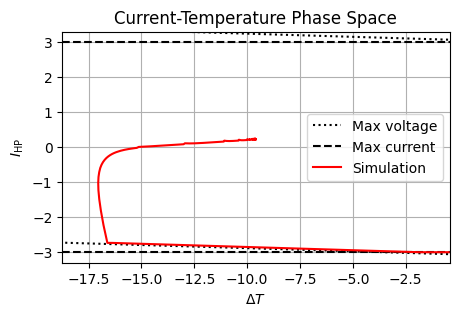

In [133]:
x_sim = results["T_HP_h"].to_numpy() - results["T_HP_c"].to_numpy()
y_sim = results["I_HP"].to_numpy()
COP_sim = results["COP"].to_numpy()

x = results[["SoC", "T_HP_c", "T_HP_h"]].to_numpy().T
u = results[["I_HP", "x_FAN"]].to_numpy().T

def get_constraints(delta_T:np.ndarray) -> np.ndarray:
    y_vec_min = (-model.U_BT_num(x, u) - model.S_M * (delta_T)) / model.R_M
    y_vec_max = (model.U_BT_num(x, u) - model.S_M * (delta_T)) / model.R_M
    return y_vec_min, y_vec_max

x_vec = np.linspace(-100, 100, len(x_sim))
y_vec_min, y_vec_max = get_constraints(x_vec)

plt.figure(figsize=(5, 3))
plt.plot(x_vec, y_vec_min, color='k', linestyle=':', label='Max voltage')
plt.plot(x_vec, y_vec_max, color='k', linestyle=':')
plt.axhline(y=model.I_HP_max, color='black', linestyle='--', label='Max current')
plt.axhline(y=-model.I_HP_max, color='black', linestyle='--')
plt.plot(x_sim, y_sim, color='r', label='Simulation')
plt.xlabel(r'$\Delta T$')
plt.ylabel(r'$I_\mathrm{HP}$')
plt.title('Current-Temperature Phase Space')

plt.xlim(x_sim.min()-abs(x_sim.min())*0.1, x_sim.max()+abs(x_sim.max())*0.1)
plt.ylim(-model.I_HP_max*1.1, model.I_HP_max*1.1)
plt.grid()
plt.legend()
plt.show()


C:\Users\giaco\AppData\Local\Temp\ipykernel_18000\4260026974.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[2]
C:\Users\giaco\AppData\Local\Temp\ipykernel_18000\4260026974.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[1]


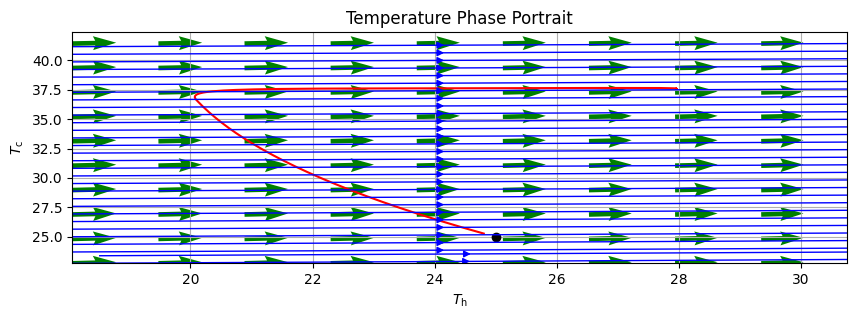

In [131]:
x_FAN = 1.0
x_SoC = 0.85
I_HP = 1.2

lenght_data = 10

# Define the system of equations dTh/dt = f3(Th, Tc) and dTc/dt = f2(Th, Tc)
def f3(Th:np.ndarray, Tc:np.ndarray) -> np.ndarray:
    tmp = np.zeros_like(Th)

    for i in range(lenght_data):
        tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[2]

    return tmp

def f2(Th:np.ndarray, Tc:np.ndarray) -> np.ndarray:
    tmp = np.zeros_like(Th)

    for i in range(lenght_data):
        tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[1]

    return tmp

Th_sim = results["T_HP_h"].to_numpy()
Tc_sim = results["T_HP_c"].to_numpy()

# Create a grid of points in the (x, y) plane
x = np.linspace(Th_sim.min()-abs(Th_sim.min())*0.1, Th_sim.max()+abs(Th_sim.max())*0.1, lenght_data)
y = np.linspace(Tc_sim.min()-abs(Tc_sim.min())*0.1, Tc_sim.max()+abs(Tc_sim.max())*0.1, lenght_data)
X, Y = np.meshgrid(x, y)

# Compute the vector field at each grid point
u = f3(x, y)
v = f2(x, y)
U, V = np.meshgrid(u, v)

# Plot the streamlines using the quiver function
plt.figure(figsize=(10, 3))
plt.quiver(X, Y, U, V, color='g')  # Arrows indicating the direction field
plt.plot(Th_sim, Tc_sim, color='r')
plt.plot(conv_temp(T_amb0, 'K', 'C'), conv_temp(T_amb0, 'K', 'C'), 'o', color='black', label='Ambient')
plt.xlabel(r"$T_\mathrm{h}$")
plt.ylabel(r"$T_\mathrm{c}$")
plt.title('Temperature Phase Portrait')

# Additionally, plot using streamplot for smoother visualization
plt.streamplot(X, Y, U, V, color='b', linewidth=1)

plt.grid()
plt.show()